# Decoding population activity

**Imports**

In [1]:
%matplotlib inline
from sym_model import Population

import sys
import seaborn as sns
import umap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.insert(0, './model')

from model import decoding
from model import persistence
from utils import get_orientation_phase_grid

## Getting the data

**Sampling the activity using the model**

In [2]:
limit = 1500
# n_theta, n_phi = 18, 24
n_theta, n_phi = 9, 12
step_phi, step_theta = 360 // n_phi, 180 // n_theta

In [3]:
grid = get_orientation_phase_grid(step_phi, step_theta)
grid = grid.reshape((-1, 2)) * 180 / np.pi
print(grid[0], grid[-1])

[0. 0.] [160. 330.]


In [4]:
res = Population.random(10).sample_responses(limit, custom_grid=grid, use_sigmoid=False)
res, phi_deg, theta_deg = res[:, :, 0], res[:, 0, 1], res[:, 0, 2]

In [5]:
import pickle
with open('res.pkl', 'wb') as f:
    pickle.dump(res, f)

In [5]:
phi_reorder = sorted(list(range(len(phi_deg[:limit]))), key=lambda x: phi_deg[x])
theta_reorder = sorted(list(range(len(theta_deg[:limit]))), key=lambda x: theta_deg[x])

In [6]:
res.shape

In [7]:
res_reshaped = res.reshape((n_phi, n_theta, -1))

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

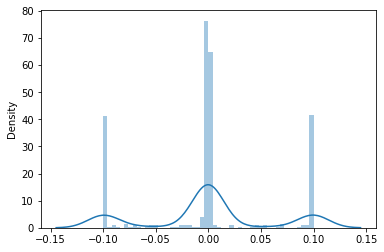

In [10]:
sns.distplot((res).ravel().clip(-0.1, 0.1))

## Plotting joint tunings

In [12]:
phase_linspace = np.linspace(0, 360, n_phi)
orientation_linspace = np.linspace(0, 180, n_theta)

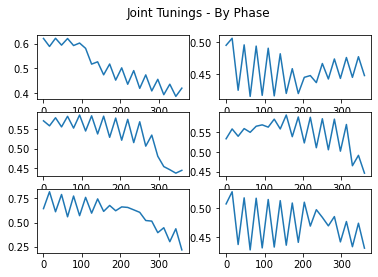

In [13]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Joint Tunings - By Phase')
for i in range(6):
    ax[i].plot(phase_linspace, res_reshaped.mean(1)[:, i])

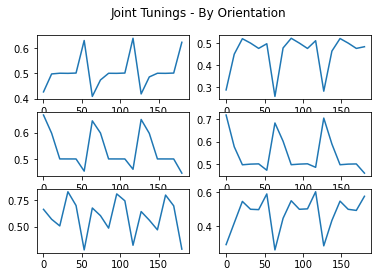

In [14]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Joint Tunings - By Orientation')
for i in range(6):
    ax[i].plot(orientation_linspace, res_reshaped.mean(0)[:, i])

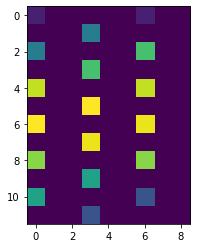

In [12]:
plt.imshow(res_reshaped[:, :, 0], cmap='viridis')

## Persistence for different dimensions

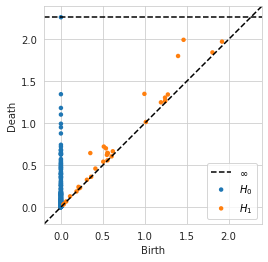

In [13]:
persistence.persistence(res, 1)

In [14]:
# persistence.persistence(res, 2)

In [15]:
# persistence.persistence(res, 3)

## PCA

In [16]:
res_df = pd.DataFrame(res[:limit], columns=['x' + str(i) for i in range(20)])

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

<AxesSubplot:>

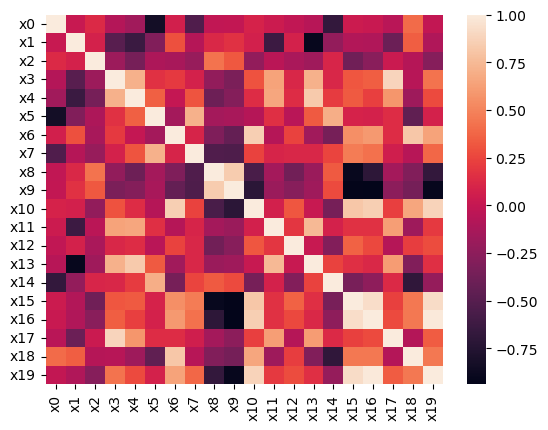

In [18]:
sns.heatmap(res_df.corr())

Seems like we need about 5 components

In [19]:
N_COMP = 6
pca = PCA(n_components=N_COMP)
pca.fit(res_df)
data_pca = pca.transform(res_df)
data_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(N_COMP)])
data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
0 -1.612520 -0.547999 -0.110458 -0.530344  0.888399 -0.105346
1 -1.007680 -0.069920 -0.222961  0.443805 -0.416626 -0.541131
2 -0.228229  0.523023  0.226259 -0.233582 -0.340139 -0.273262
3 -0.178205  0.297823  0.294549 -0.225669 -0.151865  0.018889
4  0.113908 -0.155210  0.616534  0.036769  0.003957 -0.032182

In [20]:
data_pca.shape

## UMAP decoding

In [21]:
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(data_pca.to_numpy())

In [22]:
# %matplotlib notebook
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1])
# plt.show()

In [23]:
# embedding.shape

## Cohomological decoding

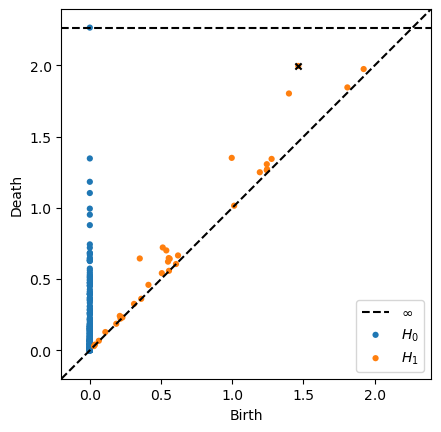

Decoding... done


In [24]:
param_1 = decoding.cohomological_parameterization(res_df, coeff=12).to_numpy()

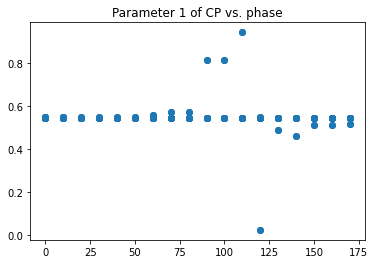

In [25]:
%matplotlib inline
plt.title("Parameter 1 of CP vs. phase")
plt.scatter(phi_deg, param_1)

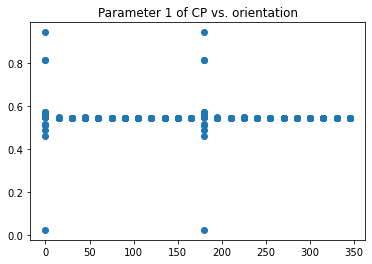

In [26]:
plt.title("Parameter 1 of CP vs. orientation")
plt.scatter(theta_deg, param_1)

In [27]:
data_without_features = decoding.remove_feature(data_pca.to_numpy(), pd.DataFrame(param_1))

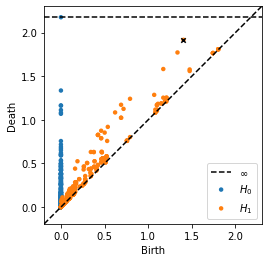

Decoding... 

In [ ]:
param_2 = decoding.cohomological_parameterization(
    pd.DataFrame(data_without_features[:limit])).to_numpy()

In [ ]:
plt.scatter([phi_deg[i] * 180 / np.pi for i in phi_reorder], [param_2[i] for i in phi_reorder])

In [ ]:
plt.scatter([theta_deg[i] for i in theta_reorder], [param_2[i] for i in theta_reorder])

In [ ]:
phi_reorder[:10]